In [28]:
from IPython.display import display, Markdown, HTML
import plotly.express as px
import itertools

from azureml.core import Run, Model
from azureml.core import Datastore, Experiment, ScriptRunConfig, Workspace, Run

from model_drift import settings
from model_drift.helpers import column_xs, correlate_performance, mutual_info_performance, w_avg
import pandas as pd
import os
import datetime



In [29]:
import pandas as pd
import six


ws = Workspace.from_config(settings.AZUREML_CONFIG)
experiment_name = 'generate-drift-csv-label-mod-dbg'
exp = Experiment(workspace=ws, name=experiment_name)


def run_to_dict(run):
    d = dict(**run.tags)
    d['id'] = run.id
    d['display_name'] = run.display_name
    d['url'] = run.get_portal_url()
    d['run'] = run
    # d["startTimeUtc"] = pd.to_datetime(run.get_details()["startTimeUtc"])
    # d["endTimeUtc"] = pd.to_datetime(run.get_details()["endTimeUtc"])
    return d


def experiment_to_dataframe(experiment, workspace=None):
    
    if isinstance(experiment, six.string_types):
        if workspace is None:
            raise ValueError("if experiment is string, must provide workspace")
        experiment = Experiment(workspace=workspace, name=experiment)
    df = []
    for run in exp.get_runs():
        if run.status != "Completed":
            continue
        df.append(run_to_dict(run))
    return pd.DataFrame(df).set_index(['display_name'])#.sort_values("endTimeUtc", ascending=False)

df = experiment_to_dataframe(exp)

run = Run(experiment=Experiment(workspace=ws, name='generate-drift-csv-3'), 
          run_id="generate-drift-csv-3_1639942528_d9f3ee90") # "tender_pear_lfbd6
df = df[~df['mod_end_date'].isnull()]

# Baseline
d = run_to_dict(run)
d["label_modifiers"] = "Baseline"
df = df.append(pd.Series(d, name=d.pop("display_name")))

df.head()

_aml_system_ComputeTargetStatus  \
display_name                                                               
sad_caravan_nnryywcw   {"AllocationState":"steady","PreparingNodeCoun...   
serene_head_v04mgvx4   {"AllocationState":"steady","PreparingNodeCoun...   
salmon_cloud_wg3s2fnq  {"AllocationState":"steady","PreparingNodeCoun...   
affable_plum_cm6y51d3  {"AllocationState":"steady","PreparingNodeCoun...   
musing_lock_mgsp9xps   {"AllocationState":"steady","PreparingNodeCoun...   

                      mlflow.source.type  \
display_name                               
sad_caravan_nnryywcw                 JOB   
serene_head_v04mgvx4                 JOB   
salmon_cloud_wg3s2fnq                JOB   
affable_plum_cm6y51d3                JOB   
musing_lock_mgsp9xps                 JOB   

                                              mlflow.source.name run_azure  \
display_name                                                                 
sad_caravan_nnryywcw   scripts/drift/generate-drift-csv-label.py         1   
serene_head_v04mgvx4   scripts/drift/generate-drift-csv-label.py         1   
salmon_cloud_wg3s2fnq  scripts/drift/generate-drift-csv-label.py         1   
affable_plum_cm6y51d3  scripts/drift/generate-drift-csv-label.py         1   
musing_lock_mgsp9xps   scripts/drift/generate-drift-csv-label.py         1   

                                                               input_dir  \
display_name                                                               
sad_caravan_nnryywcw   /mnt/batch/tasks/shared/LS_root/jobs/mlops_sha...   
serene_head_v04mgvx4   /mnt/batch/tasks/shared/LS_root/jobs/mlops_sha...   
salmon_cloud_wg3s2fnq  /mnt/batch/tasks/shared/LS_root/jobs/mlops_sha...   
affable_plum_cm6y51d3  /mnt/batch/tasks/shared/LS_root/jobs/mlops_sha...   
musing_lock_mgsp9xps   /mnt/batch/tasks/shared/LS_root/jobs/mlops_sha...   

                       output_dir   dataset       vae_dataset  \
display_name                                                    
sad_caravan_nnryywcw   ./outputs/  padchest  padchest-trained   
serene_head_v04mgvx4   ./outputs/  padchest  padchest-trained   
salmon_cloud_wg3s2fnq  ./outputs/  padchest  padchest-trained   
affable_plum_cm6y51d3  ./outputs/  padchest  padchest-trained   
musing_lock_mgsp9xps   ./outputs/  padchest  padchest-trained   

                                       classifier_dataset vae_filter  ...  \
display_name                                                          ...   
sad_caravan_nnryywcw   padchest-finetuned-chx-frontalonly   all-data  ...   
serene_head_v04mgvx4   padchest-finetuned-chx-frontalonly   all-data  ...   
salmon_cloud_wg3s2fnq  padchest-finetuned-chx-frontalonly   all-data  ...   
affable_plum_cm6y51d3  padchest-finetuned-chx-frontalonly   all-data  ...   
musing_lock_mgsp9xps   padchest-finetuned-chx-frontalonly   all-data  ...   

                      num_workers dbg  \
display_name                            
sad_caravan_nnryywcw           10   1   
serene_head_v04mgvx4           10   1   
salmon_cloud_wg3s2fnq          10   1   
affable_plum_cm6y51d3          10   1   
musing_lock_mgsp9xps           10   1   

                                                                      id  \
display_name                                                               
sad_caravan_nnryywcw   generate-drift-csv-label-mod-dbg_1642612521_b3...   
serene_head_v04mgvx4   generate-drift-csv-label-mod-dbg_1642612530_ae...   
salmon_cloud_wg3s2fnq  generate-drift-csv-label-mod-dbg_1642612524_fb...   
affable_plum_cm6y51d3  generate-drift-csv-label-mod-dbg_1642612534_c7...   
musing_lock_mgsp9xps   generate-drift-csv-label-mod-dbg_1642461065_3b...   

                                                                     url  \
display_name                                                               
sad_caravan_nnryywcw   https://ml.azure.com/runs/generate-drift-csv-l...   
serene_head_v04mgvx4   https://ml.azure.com/runs/generate-drift-csv-l...  

In [3]:
html_top_dir = settings.TOP_DIR.joinpath("html", "graphs_paper-new")
html_top_dir.mkdir(exist_ok=True)

In [4]:
def is_arg_col(c):
    if "mlflow" in c or "_aml" in c or 'run_' in c or 'url' in c:
        return False
    ignore = ["output_dir", "input_dir", 'run', 'display_name', 'id']
    return c not in ignore

def experiment_df_for_display(df, remove_duplicates=True, remove_const_columns=True):
    arg_cols = [c for c in df.columns if is_arg_col(c)]
    arg_df = df[arg_cols]
    
    if remove_const_columns:
        arg_df = arg_df[[c for c in arg_df if arg_df[c].fillna('NA').nunique() > 1]]
    
    
    if remove_duplicates:    
        arg_df[~arg_df.duplicated(keep='last')]
    
    return arg_df

arg_df = experiment_df_for_display(df)
arg_df['Link'] = [f"""<a href="{name}/index.html" disabled=>Graphs</a>""" if html_top_dir.joinpath(name).exists() else "N/A" for name in arg_df.index]

arg_df

label_modifiers  \
display_name                                                                 
sad_caravan_nnryywcw     {"Opacity": [0.75, "2014-04-01", "2014-08-15"]...   
serene_head_v04mgvx4     {"Cardiomegaly": [0.75, "2014-04-01", "2014-08...   
salmon_cloud_wg3s2fnq    {"Pleural Abnormalities": [0.75, "2014-04-01",...   
affable_plum_cm6y51d3    {"Atelectasis": [0.75, "2014-04-01", "2014-08-...   
musing_lock_mgsp9xps     {"Opacity": [0.75, "2014-06-01", "2014-09-15"]...   
mighty_beard_vvtgq0q9    {"Pleural Abnormalities": [0.75, "2014-06-01",...   
jolly_tangelo_ch7q56v0   {"Atelectasis": [0.75, "2014-06-01", "2014-09-...   
keen_circle_9wktjvvd     {"Atelectasis": [0.75, "2014-06-01", "2014-09-...   
purple_toe_dnntc2j8                                                   None   
goofy_dress_ztmzmh27                                                  None   
ivory_river_m6m000f8     {"Atelectasis": [0.5, "2014-04-01", "2014-06-3...   
serene_angle_h8wlwrl7    {"Lesion": [0.5, "2014-04-01", "2014-06-30"], ...   
helpful_beard_352vr4j8   {"Atelectasis": [0.25, "2014-04-01", "2014-06-...   
gentle_guitar_2nt9sm6t   {"Cardiomegaly": [0.25, "2014-04-01", "2014-06...   
dynamic_fish_jtn2x5q9    {"Opacity": [0.5, "2014-04-01", "2014-06-30"],...   
lemon_plane_mrb3nm7v     {"Pneumonia": [0.25, "2014-04-01", "2014-06-30...   
icy_fly_hpwms2yp         {"Pneumonia": [0.5, "2014-04-01", "2014-06-30"...   
epic_plate_nc54lhdv      {"Cardiomegaly": [0.5, "2014-04-01", "2014-06-...   
quiet_duck_8y08st8w      {"Atelectasis": [0.5, "2014-04-01", "2014-06-3...   
patient_hominy_8v6p78yh  {"Cardiomegaly": [0.75, "2014-04-01", "2014-06...   
icy_ghost_rt8dc2xp       {"No Finding": [0.1287001287001287, "2014-04-0...   
ivory_branch_d350x4yq    {"Pneumonia": [0.75, "2014-04-01", "2014-06-30...   
red_answer_rdp62h0t      {"Atelectasis": [0.75, "2014-04-01", "2014-06-...   
tender_pear_lfbd6wwg                                              Baseline   

                        mod_end_date randomize_start_date dbg peds_weight Link  
display_name                                                                    
sad_caravan_nnryywcw      2014-12-31                 None   1         NaN  N/A  
serene_head_v04mgvx4      2014-12-31                 None   1         NaN  N/A  
salmon_cloud_wg3s2fnq     2014-12-31                 None   1         NaN  N/A  
affable_plum_cm6y51d3     2014-12-31                 None   1         NaN  N/A  
musing_lock_mgsp9xps      2014-12-31                 None   1         NaN  N/A  
mighty_beard_vvtgq0q9     2014-12-31                 None   1         NaN  N/A  
jolly_tangelo_ch7q56v0    2014-12-31                 None   1         NaN  N/A  
keen_circle_9wktjvvd      2014-12-31                 None   1         NaN  N/A  
purple_toe_dnntc2j8       2014-12-31           2014-06-01   1         NaN  N/A  
goofy_dress_ztmzmh27      2014-12-31           2014-04-01   1         NaN  N/A  
ivory_river_m6m000f8      2014-12-31                  NaN   1         NaN  N/A  
serene_angle_h8wlwrl7     2014-12-31                  NaN   1         NaN  N/A  
helpful_beard_352vr4j8    2014-12-31                  NaN   1         NaN  N/A  
gentle_guitar_2nt9sm6t    2014-12-31                  NaN   1         NaN  N/A  
dynamic_fish_jtn2x5q9     2014-12-31                  NaN   1         NaN  N/A  
lemon_plane_mrb3nm7v      2014-12-31                  NaN   1         NaN  N/A  
icy_fly_hpwms2yp          2014-12-31                  NaN   1         NaN  N/A  
epic_plate_nc54lhdv       2014-12-31                  NaN   1         NaN  N/A  
quiet_duck_8y08st8w       2014-12-31                  NaN   1         NaN  N/A  
patient_hominy_8v6p78yh   2014-12-31                  NaN   1         NaN  N/A  
icy_ghost_rt8dc2xp        2014-12-31                  NaN   1         NaN  N/A  
ivory_branch_d350x4yq     2014-12-31                  NaN   1         NaN  N/A  
red_answer_rdp62h0t       2014-12-31                  NaN   1         NaN  N/A  
tende

In [5]:
fix_links_script = """
              <script>
                var x = document.getElementsByTagName('a');
                var i;
                for (i = 0; i < x.length; i++) {{
                    let url = x[i].getAttribute("href");
                    x[i].href = url + window.location.search;
                }}
                </script>
              """

In [6]:
def get_run(display_name, experiment):
    for run in experiment.get_runs():
        if run.display_name == display_name:
            return run
        
    raise KeyError(f"'{display_name}' not found in experiment!")

In [7]:
import itertools
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import colors as mpl_colors
from collections import defaultdict

def to_rgba(rgb, alpha=None):
    rgb = mpl_colors.to_rgb(rgb)
    if alpha is None:
        return "rgb(%s, %s, %s)" % (rgb[0], rgb[1], rgb[2])
    return "rgba(%s, %s, %s, %s)" % (rgb[0], rgb[1], rgb[2], alpha)

def line_maker(color, **l):
    return dict(color=color, **l)

def marker_maker(color, **l):
    return dict(color=color)

def smooth(y: pd.DataFrame, span=7):
    if span > 0:
        ys = y.ewm(span=span, ignore_na=False).mean()
        ys[y.isna()] = None
    else:
        ys = y    
    return ys

def add_date_line(fig, date, name, y=1.08):
    fig.add_shape(type='line',
                x0=date,
                y0=0,
                x1=date,
                y1=1,
                line=dict(color='black', dash='dot'),
                xref='x',
                yref='paper'
                )
    fig.add_annotation(textangle=0,
                    xref="x",
                    yref="paper", x=date, y=y,
                       text=name, showarrow=False,
                       font=dict(size=18))

def add_dates(fig, dates, line_y=1.05, include_date=True):
    for name, date in dates.items():
        if not pd.isna(date):
            n = f"{name}<br />({date})" if include_date else name
            add_date_line(fig, date, n, y=line_y)
            
def collect_corr(y, yp, name, when, weights_name, start_date=None, end_date=None):
    yp = yp.loc[start_date: end_date]
    y = y.loc[start_date: end_date]
    c, cm = yp.corr(y), smooth(yp).corr(smooth(y))
    return {"name": name, "weights_name": weights_name,
                "corr (raw)": c, "corr (smoothed)": cm, "when": when}

class FigureHelper(object):
    
    def __init__(self, x=None, color_list=px.colors.qualitative.Plotly, dashes=('solid',), smooth_func=smooth, merge_hover=True):
        self.traces = []
        self.error_traces = []
        self.color_list = color_list
        self.line_picker = itertools.cycle(itertools.product(dashes, self.color_list))
        self.lines = defaultdict(lambda: dict(zip(['dash', 'color'], next(self.line_picker))))
        self.names = set()
        self.smooth = smooth_func
        self.x = x
        self.merge_hover = merge_hover
        
    def set_line(self, key, line=None):
        line = line or {}
        self.lines[key] = self.lines[key]
        self.lines[key].update(line)
        self.lines[key]['color'] = self.lines[key]['color']
        return self.lines[key]
        
        
    def make_error_traces(self, x, yu, yl, name, color, alpha):
        
        
        # need to remove nans from error traces
        k = ~(yu.isnull()|yl.isnull())
        xe = x[k]
        yl = yl[k]
        yu = yu[k]
        
        return [go.Scatter(x=xe, 
                            y=yu, 
                            hoverinfo="skip",
                            showlegend=False,
                            legendgroup=name,
                            name=name,
                            connectgaps=False,
                            line=dict(width=0),
                ), 
                go.Scatter(x=xe, 
                            y=yl,
                            fillcolor=to_rgba(color, alpha),
                            fill='tonexty',
                            hoverinfo="skip",
                            showlegend=False,                            
                            legendgroup=name,
                            name=name,
                            connectgaps=False,
                            line=dict(width=0),
                )]

    def add_trace(self, y, name, x=None, kind=go.Scatter, color_key=None, row=1, col=1, line=None,
                  std=None, yu=None, yl=None, **trace_kwargs):
        color_key = color_key or name
        trace_kwargs.setdefault('showlegend', name not in self.names)
        self.names.add(name)
        trace_kwargs.setdefault('legendgroup', name)
        
        line = self.set_line(color_key, line)
        x = x or self.x
        y = y.reindex(x)
        t = kind(x=x, y=y, name=name, **trace_kwargs)
        if not isinstance(t, go.Bar):
            t.line = line_maker(**line)
        else:
            t.marker = marker_maker(**line)
            
    
        self.traces.append((row, col, t))
        
        if std is not None:
            yu = y+std
            yl = y-std
            
        if yu is not None and yl is not None:
            for t_ in self.make_error_traces(x, yu, yl, name=name, color=line["color"], alpha=0.2):
                self.error_traces.append((row, col, t_))
    
    
    def add_bar(self, y, name, x=None, color_key=None, row=1, col=1, line=None, include_line=True,
                **trace_kwargs):
        
        if include_line:
            self.add_trace(y=y, name=name, color_key=color_key, line=line, row=row, col=col, **trace_kwargs)
        self.add_trace(y=y, name=name, color_key=color_key, kind=go.Bar, line=line, row=row, col=col, **trace_kwargs)
        
        
    
    def make_fig(self, **fig_kwargs):

        data = {}
        max_row = 1
        max_col = 1
        for r, c, t in self.traces:
            max_row = max(r, max_row)
            max_col = max(c, max_col)
            data[t.name] = pd.Series(t.y, index=t.x)
            
        customdata = pd.DataFrame(data)
        fig = make_subplots(rows=max_row, cols=max_col, **fig_kwargs)
        for r, c, t in self.traces:
            if self.merge_hover:
                cus_cols = sorted(customdata)
                ho = "<br />".join(["{name}=%{{customdata[{i}]:.3f}}".format(i=i, name=name) for i,name in enumerate(cus_cols)])
                hovertemplate = "%{x}<br>" + f"{t.name}: " +"%{y}<br><br>"+f"{ho}<extra></extra>"
                t.customdata = customdata[cus_cols]
                t.hovertemplate = hovertemplate
            # t.hoverlabel = {'bgcolor': 'white'}
            fig.add_trace(t, row=r, col=c)
                        
        for r, c, t in self.error_traces:
            fig.add_trace(t, row=r, col=c)
        return fig
        
        
        
        

In [8]:
def download_and_prepare_run_data(run, which="mean"):
    output_file_path = settings.TOP_DIR.joinpath('results', 'drift', run.display_name+".csv")
    fname = str(output_file_path)
    run.download_file("outputs/output.csv", output_file_path=output_file_path)
    
    combined_df = pd.read_csv(str(fname), index_col=0, header=[0, 1, 2, 3])
    combined_df.index = pd.to_datetime(combined_df.index)
    flip = column_xs(combined_df, include=["pval"])
    combined_df[flip] = 1-combined_df[flip]
    
    error_df = combined_df.swaplevel(0, -1, axis=1)[["std"]].swaplevel(0, -1, axis=1).droplevel(-1, axis=1).copy()
    combined_df = combined_df.swaplevel(0, -1, axis=1)[[which]].swaplevel(0, -1, axis=1).droplevel(-1, axis=1).copy()
    
    return error_df, combined_df


def calc_stats(other_df, standardize_dates):
    standardize_ix = pd.date_range(*standardize_dates)
    stats = other_df.dropna(axis=1).reindex(standardize_ix)
    stats = stats.agg(["mean", "std"])
    return stats

def standardize(other_df, standardize_dates=None, stats=None, clip=None) -> pd.DataFrame:
    
    if stats is None:
        stats = calc_stats(other_df, standardize_dates)
    otherstd = other_df.copy()
    # cannot divide by zero
    std0 = stats.loc['std'] == 0
    stats.loc["std", stats.loc['std'] == 0] = 1
    
    otherstd = (otherstd-stats.loc['mean'])/(stats.loc["std"])
    bad_cols = otherstd.columns[otherstd.isnull().max(axis=0)].tolist()
    print("bad columns after standardization:", bad_cols)
    
    if clip is not None:
        otherstd = otherstd.clip(-1*clip, clip)
    
    return otherstd

def calculate_weights(yp, otherstd) -> pd.DataFrame:
    all_corr_df = correlate_performance(yp.rename('auroc'), otherstd)
    all_ig_df = mutual_info_performance(yp.rename('auroc'), otherstd, bins=25)
    m_ = all_ig_df.to_frame().join(all_corr_df.abs().rename('abs(corr)'))
    m_ = m_.join(m_.mean(axis=1).rename('mean[abs(corr),info_gain]'))
    m_ = m_.assign(no_weights=1)
    m_ = m_.fillna(0)
    
    return m_

class DriftFromRun(object):
    
    which = "mean"
    standardize_dates = (settings.PADCHEST_SPLIT_DATES[0], settings.PADCHEST_SPLIT_DATES[1])
    stat = ['distance']
    span = 7
    clip = 10
    performance_col = ("performance", "micro avg", "auroc")
    # performance_col = ("performance", "Pneumonia", "auroc")
    # performance_col = ("performance", "Pleural Abnormalities", "auroc")
    graph_start = "2014-01-01"
    graph_end = "2014-12-31"
    
    def __init__(self, run):
        
        error_df, combined_df = download_and_prepare_run_data(run, which=self.which)
        perf_df = combined_df[self.performance_col]
        other_cols = column_xs(combined_df, exclude=['performance', 'count'])
        other_df = combined_df[other_cols]
        cxs = column_xs(other_df, include=self.stat)
        otherstd = standardize(other_df[cxs], self.standardize_dates, clip=self.clip)
        
        self.standardize_ix = pd.date_range(*self.standardize_dates)
        
        count_cols = column_xs(combined_df, ['support'])
        count_cols = [c for c in count_cols if 'avg' not in c[1]]
        label_counts = combined_df[count_cols]
        label_counts.columns = [c[1] for c in label_counts.columns]
        num_samples = combined_df['count'].iloc[:, 0]
        
        self.label_rates = label_counts.div(num_samples, axis=0)
        
        vae_cols = [c for c in list(otherstd) if "mu." in c[0]]
        score_cols = [c for c in list(otherstd) if "activation." in c[0]]
        metadata_cols = sorted(set(otherstd).difference(vae_cols).difference(score_cols))
        
        self.other_cols = other_cols
        self.vae_cols = vae_cols
        self.score_cols = score_cols
        self.metadata_cols = metadata_cols
        
        self.combined_df = combined_df
        self.otherstd = otherstd
        self.perf_df = perf_df
        self.perf_error_df = error_df[self.performance_col]
        self.m_ = calculate_weights(perf_df.reindex(self.standardize_ix), otherstd.reindex(self.standardize_ix))
        
    def unify_metrics(self, cols=None, weights="abs(corr)", start=None, end=None, m=None):
        if cols is None:
            cols = self.otherstd.columns.tolist()
        if m is None:
            m=self.m_
        return -w_avg(self.otherstd[cols], weights=m[weights].to_dict())


In [9]:
import tqdm

In [19]:
normal = ("silly_arch_hf40trym", "generate-drift-csv-5")


runs_for_w = {
#  ('g0', 'b1.0'): ('loyal_watch_hc1q84kj', 'generate-drift-csv-5'),
#  ('g0', 'b0.5'): ('stoic_lime_f2rkw6sk', 'generate-drift-csv-5'),
#  ('g0', 'b0.25'): ('cool_kite_dz6kjc7r', 'generate-drift-csv-5'),
#  ('g0', 'b0.1'): ('magenta_nerve_vwt90850', 'generate-drift-csv-5'),
#  ('g0', 'b0.05'): ('kind_pizza_xpx508k7', 'generate-drift-csv-5'),
#  ('g1.0', 'b0'): ('loyal_fly_ltjqq1p1', 'generate-drift-csv-5'),
#  ('g0.5', 'b0'): ('khaki_dog_8cg475qh', 'generate-drift-csv-5'),
#  ('g0.25', 'b0'): ('sincere_bird_2qldm7v9', 'generate-drift-csv-5'),
 ('g0.1', 'b0'): ('goofy_skin_4y971rhz', 'generate-drift-csv-5'),
 ('g0.05', 'b0'): ('quiet_tent_n8bn1fjf', 'generate-drift-csv-5'),
 "normal": normal
 }



extra_builds = {}
extra_data_for_w = {}
extra_perf_for_w = {}

run_name, experiment = normal
experiment = Experiment(ws, experiment)
run = get_run(run_name, experiment)
build = DriftFromRun(run)

stats = calc_stats(build.combined_df[build.other_cols], build.standardize_dates)

stats

for k, (run_name, experiment) in tqdm.tqdm(runs_for_w.items()):
    experiment = Experiment(ws, experiment)
    run = get_run(run_name, experiment)
    build = DriftFromRun(run)
    extra_builds[k] = build
    standardize_ix = pd.date_range(*build.standardize_dates)
    other_df = build.combined_df.reindex(standardize_ix)[build.other_cols]
    
    extra_data_for_w[k] = (standardize(other_df, stats=stats).reindex(standardize_ix)
                           .join(build.perf_df.reindex(standardize_ix)))
    

bad columns after standardization: []


D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning:

merging between different levels can give an unintended result (3 levels on the left,1 on the right)

  0%|          | 0/3 [00:00<?, ?it/s]

bad columns after standardization: []


D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning:

merging between different levels can give an unintended result (3 levels on the left,1 on the right)

 33%|███▎      | 1/3 [00:12<00:25, 12.82s/it]

bad columns after standardization: []
bad columns after standardization: []


D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning:

merging between different levels can give an unintended result (3 levels on the left,1 on the right)

 67%|██████▋   | 2/3 [00:26<00:13, 13.17s/it]

bad columns after standardization: []
bad columns after standardization: []


D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning:

merging between different levels can give an unintended result (3 levels on the left,1 on the right)

100%|██████████| 3/3 [00:38<00:00, 12.76s/it]

bad columns after standardization: []


In [20]:
extra_data_for_w_df = pd.concat(extra_data_for_w.values()).reset_index(drop=True)

extra_perf_df = extra_data_for_w_df[build.performance_col]

extra_drift_df = extra_data_for_w_df.drop(build.performance_col, axis=1)
extra_drift_df[build.otherstd.columns]
# extra_perf_df.plot()

BitsStored_DICOM Columns_DICOM Exposure_DICOM Manufacturer_DICOM  \
                 chi2            ks           chi2               chi2   
             distance      distance       distance           distance   
0            2.307328      1.646317       0.575100           2.494714   
1            2.254034      1.772549       0.604306           2.563559   
2            3.057774      1.341574       0.353827           1.925386   
3            2.150901      1.312831       0.343900           1.819326   
4            2.838679      1.137374       0.262778           1.581419   
...               ...           ...            ...                ...   
1093        -0.714543      2.764122      -0.242221          -0.914048   
1094        -0.734690      2.969136      -0.436079          -0.981261   
1095        -0.692112      3.327625      -0.326239          -0.982644   
1096        -0.698531      3.321756      -0.447105          -0.977602   
1097        -0.716610      3.224524      -0.410529          -0.972380   

     Modality_DICOM PatientSex_DICOM PhotometricInterpretation_DICOM  \
               chi2             chi2                            chi2   
           distance         distance                        distance   
0               0.0         1.390044                             0.0   
1               0.0         1.647537                             0.0   
2               0.0         1.637328                             0.0   
3               0.0         2.045997                             0.0   
4               0.0         2.145943                             0.0   
...             ...              ...                             ...   
1093            0.0        -0.625888                             0.0   
1094            0.0        -0.452317                             0.0   
1095            0.0        -0.612076                             0.0   
1096            0.0        -0.560136                             0.0   
1097            0.0        -0.624647                             0.0   

     PixelAspectRatio_DICOM PixelRepresentation_DICOM Projection  ...  \
                       chi2                      chi2       chi2  ...   
                   distance                  distance   distance  ...   
0                  2.647290                       0.0   4.060678  ...   
1                  2.541011                       0.0   4.371292  ...   
2                  2.072792                       0.0   3.616954  ...   
3                  1.871655                       0.0   3.820701  ...   
4                  1.921546                       0.0   3.791162  ...   
...                     ...                       ...        ...  ...   
1093              -0.798981                       0.0  -0.162094  ...   
1094              -0.852196                       0.0   0.000037  ...   
1095              -0.859381                       0.0   0.048978  ...   
1096              -0.863303                       0.0  -0.136824  ...   
1097              -0.854551                       0.0  -0.092230  ...   

        mu.118    mu.119    mu.120    mu.121    mu.122    mu.123    mu.124  \
            ks        ks        ks        ks        ks        ks        ks   
      distance  distance  distance  distance  distance  distance  distance   
0     0.461197  0.113283 -0.033145 -0.723676 -1.153846 -1.156048 -0.372903   
1     0.655928 -0.067308 -0.312025 -0.818106 -1.283564 -1.074976 -0.320858   
2     0.172632  0.168751 -0.188623 -0.706808 -1.227237 -1.001055 -0.808338   
3     0.215253  0.299336  0.164487 -1.033899 -0.697703 -0.915864 -0.941896   
4     0.273094  0.067296  0.033154 -0.800126 -0.867261 -1.007443 -0.724947   
...        ...       ...       ...       ...       ...       ...       ...   
1093  2.842965 -0.203006 -0.742780  0.567117  0.267100 -0.425107 -0.762331   
1094  2.510830 -0.380507 -0.709446  0.224390  0.354837 -0.431528 -0.904367   
1095  2.580424  0.155860 -0.816122  0.477755  0.482006 -0.547450  0.095894   
1096  2.384822

In [21]:
mega_m = calculate_weights(extra_perf_df, extra_drift_df)

D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\.venv\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning:

merging between different levels can give an unintended result (3 levels on the left,1 on the right)



  0%|          | 0/5 [00:00<?, ?it/s]

baddata2m-5-wgt_distance_micro-avg
All Data
bad columns after standardization: []


 20%|██        | 1/5 [00:10<00:41, 10.38s/it]

Q=0.5
bad columns after standardization: []


 40%|████      | 2/5 [00:21<00:32, 10.84s/it]

Q=0.25
bad columns after standardization: []


 60%|██████    | 3/5 [00:31<00:21, 10.52s/it]

Q=0.1
bad columns after standardization: []


 80%|████████  | 4/5 [00:46<00:12, 12.30s/it]

Q=0.05
bad columns after standardization: []


100%|██████████| 5/5 [01:03<00:00, 12.77s/it]


<AxesSubplot:>

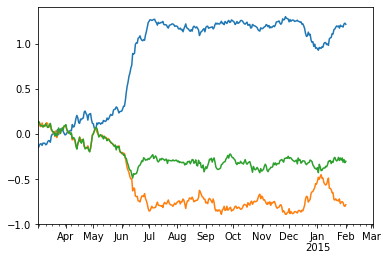

In [23]:
big = False
include_wgt = True

bname = "baddata2m-{}"

if big:
    bname += "-lg"
    
if include_wgt:
    bname += "-wgt"

figure_name = "_".join([bname, "+".join(DriftFromRun.stat), DriftFromRun.performance_col[1].replace(' ', '-').lower()])

# runs = {
#     "All Data": ("jolly_picture_78nlw5vh", "generate-drift-csv-4"),
#     # "Q=0.9": ("lucid_house_8n42r2b3", "generate-drift-csv-4"),
#     "Q=0.5": ("honest_key_p5qvhxrj", "generate-drift-csv-4"),
#     "Q=0.25": ("tidy_dream_0b07rxx6", "generate-drift-csv-4"),
#     "Q=0.1": ("gentle_pillow_63zsrc7z", "generate-drift-csv-4"),
#     "Q=0.05": ("ashy_cushion_wyf2g5vb", "generate-drift-csv-4"),
#     }

runs = {
    "All Data": ("silly_arch_hf40trym", "generate-drift-csv-5"),
    "Q=0.5": ("strong_flag_2zm4kvz1", "generate-drift-csv-5"),
    "Q=0.25": ("busy_stamp_q802wmrn", "generate-drift-csv-5"),
    "Q=0.1": ("mighty_flower_58thdzjd", "generate-drift-csv-5"),
    "Q=0.05": ("helpful_cloud_h2kybxkm", "generate-drift-csv-5"),
    }

figure_name = figure_name.format(len(runs))
print(figure_name)
verbose_name = "baseline"
graph_start = "2014-04-01"
graph_end = "2015-02-01"

x = pd.date_range(pd.to_datetime(graph_start)-pd.DateOffset(n=30), pd.to_datetime(graph_end)+pd.DateOffset(n=30))

runs_ = {}
builds = {}
score_graphs = {}
perf_graphs = {}
score_nw = {}
scores_vae = {}
scores_metadata = {}
scores_score = {}

score_graphs_mega = {}
score_graphs_megaw = {}
score_graphs_megaw2 = {}

floor_v = .5

import warnings
warnings.filterwarnings("ignore")

for name, (run_name, experiment) in tqdm.tqdm(runs.items()):
    print(name)
    experiment = Experiment(ws, experiment)
    run = get_run(run_name, experiment)
    build = DriftFromRun(run)
    runs_[name] = run
    builds[name] = build
    score_graphs[name] = build.unify_metrics().reindex(x)
    score_nw[name] = build.unify_metrics(weights="no_weights").reindex(x)
    perf_graphs[name] = pd.concat([build.perf_df.reindex(x).rename("yp"), 
                                   build.perf_error_df.reindex(x).rename("ye")], axis=1)
    
    scores_vae[name] = build.unify_metrics(cols=build.vae_cols).reindex(x)
    scores_metadata[name] = build.unify_metrics(cols=build.metadata_cols).reindex(x)
    scores_score[name] = build.unify_metrics(cols=build.score_cols).reindex(x)
    
    mega_m2 = 1-mega_m.loc[build.otherstd.columns]
    mega_m2 = mega_m2[mega_m2>mega_m2.quantile(floor_v)].fillna(0)
    
    
    m2 = build.m_.loc[build.otherstd.columns].copy()
    m2 = m2[m2>m2.quantile(floor_v)].fillna(0)
    
    score_graphs_mega[name] = build.unify_metrics(m=mega_m).reindex(x)  
    score_graphs_megaw[name] = build.unify_metrics(m=mega_m2).reindex(x)       
    score_graphs_megaw2[name] = build.unify_metrics(m=m2).reindex(x)
    
    

(score_nw["Q=0.05"]-score_graphs_mega["Q=0.05"]).plot()    
(score_nw["Q=0.05"]-score_graphs_megaw["Q=0.05"]).plot()
(score_nw["Q=0.25"]-score_graphs_megaw["Q=0.25"]).plot()
# (score_nw["Q=0.05"]-score_graphs_megaw2["Q=0.05"]).plot()

In [24]:
dates = {"A": "2014-06-01"}
dates

{'A': '2014-06-01'}

In [27]:
big = False
include_wgt = True
old = True
zeroed = True

bname = "baddata2-{}"

if big:
    bname += "-lg"
    
if include_wgt:
    bname += "-wgt"
    
    
show = ['All Data', 
        'Q=0.5',
        'Q=0.25', 
        'Q=0.1', 
        'Q=0.05']

figure_name = "_".join([bname, "+".join(DriftFromRun.stat), DriftFromRun.performance_col[1].replace(' ', '-').lower()])


figure_name = figure_name.format(len(show))
print(figure_name)


fh = FigureHelper(x, color_list=['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#8C564B', '#7f7f7f'])

row_heights = []
layout = {}
mmw_range = [-4, 1]
row=1
height = 300
row_heights.append(.2)
for name, score_unify in perf_graphs.items():
    if name not in show: continue
    fh.add_trace(y=smooth(score_unify["yp"], span=7), 
                 yu=smooth(score_unify["yp"]+score_unify["ye"], span=7),
                 yl=smooth(score_unify["yp"]-score_unify["ye"], span=7), name=name, connectgaps=False, row=row, col=1, showlegend=True)

if include_wgt:
    row += 1
    row_heights.append(.2)
    height += 300 
    for name, score_unify in score_nw.items():
        if name not in show: continue
        line = fh.lines[name]
        line["dash"] = "dot"
        layout["yaxis"+str(row)] = dict(range=mmw_range, title="$MMC_0$")
        fh.add_trace(y=smooth(score_unify, span=7), name= name + " - No Weights", connectgaps=False, row=row, col=1, line=line, legendgroup=name)

if old:
    row += 1
    row_heights.append(.2)
    height += 300 
    for name, score_unify in score_graphs.items():
        if name not in show: continue
        line = fh.lines[name]
        line["dash"] = "solid"
        layout["yaxis"+str(row)] = dict(range=mmw_range, title="$MMC_w$ old")
        fh.add_trace(y=smooth(score_unify, span=7), name=name, connectgaps=False, row=row, col=1, legendgroup=name, line=line)
    

row += 1
row_heights.append(.2)
height += 300 
for name, score_unify in score_graphs_mega.items():
    if name not in show: continue
    line = fh.lines[name]
    line["dash"] = "solid"
    layout["yaxis"+str(row)] = dict(range=mmw_range, title="$MMC_w$")
    fh.add_trace(y=smooth(score_unify, span=7), name=name, connectgaps=False, row=row, col=1, legendgroup=name, line=line)

if zeroed:
    row += 1
    row_heights.append(.2)
    height += 300 
    for name, score_unify in score_graphs_megaw.items():
        if name not in show: continue
        line = fh.lines[name]
        line["dash"] = "solid"
        layout["yaxis"+str(row)] = dict(range=mmw_range, title="$MMC_w$ zeroed")
        fh.add_trace(y=smooth(score_unify, span=7), name=name, connectgaps=False, row=row, col=1, legendgroup=name, line=line)
    
    
if old:
    row += 1
    row_heights.append(.2)
    height += 300 
    for name, score_unify in score_graphs_megaw2.items():
        if name not in show: continue
        line = fh.lines[name]
        line["dash"] = "solid"
        layout["yaxis"+str(row)] = dict(range=mmw_range, title="$MMC_w$ old q")
        fh.add_trace(y=smooth(score_unify, span=7), name=name, connectgaps=False, row=row, col=1, legendgroup=name, line=line)

if big:
    row += 1
    row_heights.append(.1)
    height += 200
    layout["yaxis"+str(row)] = dict(title="$MMC_w(VAE)$")
    for name, score_unify in scores_vae.items():
        if name not in show: continue
        fh.add_trace(y=smooth(score_unify, span=7), name=name, connectgaps=False, row=row, col=1, legendgroup=name)
        
    row += 1
    row_heights.append(.1)
    height += 200
    layout["yaxis"+str(row)] =  dict(title="$MMC_w(score)$")
    for name, score_unify in scores_score.items():
        if name not in show: continue
        fh.add_trace(y=smooth(score_unify, span=7), name=name, connectgaps=False, row=row, col=1, legendgroup=name)
        
        
    row += 1
    row_heights.append(.1)
    height += 200
    layout["yaxis"+str(row)] =  dict(title="$MMC_w(metadata)$")
    for name, score_unify in scores_metadata.items():
        if name not in show: continue
        fh.add_trace(y=smooth(score_unify, span=7), name=name, connectgaps=False, row=row, col=1, legendgroup=name)



fig = fh.make_fig(shared_xaxes=True, vertical_spacing=0.025, row_heights=[.2]*row)

if row < 3:
    add_dates(fig, dates, line_y=1.045, include_date=False)
else:
    add_dates(fig, dates, line_y=1.025, include_date=False)
fig.update_xaxes(showspikes=True, spikecolor="black", spikesnap="cursor", spikemode="across", spikethickness=1)
fig.update_layout(spikedistance=1000)
fig.update_layout(height=height)
fig.update_layout(legend={"x": .5, "orientation":"h", "borderwidth": .5, "xanchor": "center",})
fig.update_xaxes(range=[graph_start, graph_end])
fig.update_layout(yaxis1=dict(
        title=f"AUROC ({DriftFromRun.performance_col[1].title()})"),
    **layout
    )
fig.update_layout(barmode='overlay')
fig.update_layout(font=dict(size=13))
fig.update_layout(plot_bgcolor="#E8E8EA")

xaxis = dict(
        tickformat = '%Y-%m-%d',
        tickmode = 'linear',
        dtick = "M1"
    )
fig.update_layout(
    xaxis1=xaxis,
    xaxis2=xaxis,
    xaxis3 = xaxis,
)

fig.show()

baddata2-5-wgt_distance_micro-avg


In [16]:
import plotly.io as pio

fname = html_top_dir.joinpath(figure_name+".svg")
pio.write_image(fig, fname, scale=1, width=5*300, height=height)
print(fname)

relfname = os.path.relpath(str(fname), os.getcwd())
display(HTML(f"""<img src="{relfname}" />"""))

D:\Code\MLOpsDay2\MedImaging-ModelDriftMonitoring\html\graphs_paper-new\baddata2-weirdthing-5-wgt_distance_micro-avg.svg


In [ ]:
raise

In [ ]:

output_file_path = settings.TOP_DIR.joinpath('results', 'drift', name+".csv")
fname = str(output_file_path)
r.download_file("outputs/output.csv", output_file_path=output_file_path)
# # Settings to file CSV file

# display_args = ["span", "which", "clip", "standardize_perf", "shift_drift_to_perf", "performance_col", "this_center", "this_range", "standardize_dates", "stat", "add_error_bars"]
d = locals()
display_args = {k: d[k] for k in display_args if k in d}

print(display_args)


if not os.path.exists(fname):
    raise ValueError("no fn")

combined_df_o = pd.read_csv(str(fname), index_col=0, header=[0, 1, 2, 3])
combined_df_o.index = pd.to_datetime(combined_df_o.index)

flip = column_xs(combined_df_o, include=["pval"])
combined_df_o[flip] = 1-combined_df_o[flip]
combined_df = combined_df_o.copy()


smooth_name = f"ewm{span}"

error_df = combined_df.swaplevel(0, -1, axis=1)[["std"]].swaplevel(0, -1, axis=1).droplevel(-1, axis=1).copy()
combined_df = combined_df.swaplevel(0, -1, axis=1)[[which]].swaplevel(0, -1, axis=1).droplevel(-1, axis=1).copy()

html_dir = html_top_dir.joinpath(name)
perf_col_name = '-'.join(performance_col)

if not os.path.exists(html_dir):
    os.makedirs(html_dir)

stat_str = '+'.join(stat)
fn = f"{html_dir}/{which}_{stat_str}_stdclip{clip}_smooth-{smooth_name}_{perf_col_name}.html"

print("output:", fn)
def is_arg_col(c):
    if "mlflow" in c or "_aml" in c or 'run_' in c or 'url' in c:
        return False

    ignore = ["output_dir", "input_dir", 'run', 'display_name', 'id']
    return c not in ignore

arg_row = run_row[arg_cols].copy()
display_row = pd.Series(display_args)
params = pd.concat({'Drift': arg_row, "Display": display_row}, axis=0).rename("Value").to_frame()

if write_html:
    with open(fn, 'w') as f:
        print("""
            <style>
            table {
            font-family: arial, sans-serif;
            border-collapse: collapse;
            width: 80%;
            }

            td, th {
            border: 1px solid #dddddd;
            text-align: left;
            padding: 8px;
            }

            tr:nth-child(even) {
            background-color: #dddddd;
            }
            </style>
        """, file=f)
        print(f"""
            <h1>Drift report</h1> created: {datetime.datetime.now()}
            <br /><br />
            <h2>Arguments </h2>
            {params.to_html()}
            """, file=f)

def shift_to_other(this, other, this_range=None, this_center=None):
    u = other.mean()
    r = other.std()#other.max()-other.min()

    if this_range is None:
        this_range = this.std()#this.max()-this.min()

    if this_center is None:
        this_center = this.mean()
    return (this-this_center)/(this_range)*r+u

perf_col = performance_col
perf_df = combined_df[perf_col]


other_cols = column_xs(combined_df, exclude=['performance', 'count'])
other_df = combined_df[other_cols]


cxs = column_xs(other_df, include=stat)


stats = pd.concat([other_df[cxs].dropna(axis=1), extra_valids[cxs].dropna(axis=1)], axis=0).sort_index()
stats = stats.loc[standardize_ix]
stats = stats.agg(["mean", "std"])


stats.T

otherstd = other_df[cxs].copy()

# cannot divide by zero
std0 = stats.loc['std'] == 0
stats.loc["std", stats.loc['std'] == 0] = 1
otherstd = (otherstd-stats.loc['mean'])/(stats.loc["std"])
errorstd = (error_df[cxs]-stats.loc['mean'])/(stats.loc["std"])
bad_cols = otherstd.columns[otherstd.isnull().max(axis=0)].tolist()

print(bad_cols)

vae_cols = [c for c in list(otherstd) if "mu." in c[0]]
score_cols = [c for c in list(otherstd) if "activation." in c[0]]
metadata_cols = sorted(set(otherstd).difference(vae_cols).difference(score_cols))

if clip is not None:
  otherstd = otherstd.clip(-1*clip, clip)

In [ ]:
x = pd.date_range(combined_df.index.min(), combined_df.index.max())


yp = combined_df[perf_col].reindex(x)
perf_error_df = error_df[perf_col].reindex(x)

all_corr_df = correlate_performance(yp.rename('auroc'), otherstd)
all_ig_df = mutual_info_performance(yp.rename('auroc'), otherstd, bins=25)
m_ = all_ig_df.to_frame().join(all_corr_df.abs().rename('abs(corr)'))
m_ = m_.join(m_.mean(axis=1).rename('mean[abs(corr),info_gain]'))
m_ = m_.assign(no_weights=1)
m_ = m_.fillna(0)

true_counts = combined_df_o['count'].droplevel([0, 1], axis=1)['obs']
count_df = combined_df['count'].reindex(x)


dates = {"Laterals Injected": run_row['nonfrontal_add_date'],
         "Frontals Removed": run_row['frontal_remove_date'],
         "Peds Added": run_row['peds_start_date'],
         "Peds Stop": run_row['peds_end_date'],
         "Val Start": settings.PADCHEST_SPLIT_DATES[0],
        #  "Test Start": settings.PADCHEST_SPLIT_DATES[1],
         }

x = x[x<graph_end]

In [ ]:
weight_names = {"no_weights": r"$MMC$", "abs(corr)": r"$MMC_w$",}

In [ ]:
m = m_.copy()

yp = yp.reindex(x)
otherstd = otherstd.reindex(x)
counts = combined_df['count'].iloc[:, 0].reindex(x)
counts2 = true_counts.reindex(x)

#collect_corr(y, yp, name, when, weights_name, start_date=None, end_date=None)
row=1
fh = FigureHelper(x)
fh.add_trace(y=smooth(yp), name="AUROC", connectgaps=False, line={"color": "blue"}, 
             yu=smooth(yp+perf_error_df.reindex(x)), 
             yl=smooth(yp-perf_error_df.reindex(x)),
             row=row, col=1)
# row += 1
# fh.add_trace(y=smooth(combined_df[congruency_measure_col]*100), row=row, name='% In-distr.', line={"color": "purple"})
row += 1
errorstd = errorstd[otherstd.columns]

for i, (name, vname) in enumerate(weight_names.items()):
    weights = m_[name].sort_values(ascending=False)
    # weights = weights.iloc[:5]
    y = -w_avg(otherstd.reindex(x), weights=weights.to_dict())
    ystd = -w_avg(errorstd.reindex(x), weights=weights.to_dict())
    fh.add_trace(y=smooth(y),
                        # customdata=smooth(yo),
                        showlegend=True, legendgroup=vname,
                        name=vname,  
                        connectgaps=False, row=row, col=1)

# display(HTML("""<script async="async" src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-AMS-MML_HTMLorMML"></script>
#     <script type="text/x-mathjax-config">MathJax.Hub.Config({"tex2jax": {"inlineMath": [["$", "$"], ["\\(", "\\)"]], "processEscapes": true, "ignoreClass": "document", "processClass": "math|output_area"}})</script>"""))

fig = fh.make_fig(shared_xaxes=True, vertical_spacing=0.025, row_heights=[.2]*row)
add_dates(fig, dates, line_y=1.045, include_date=False)
fig.update_xaxes(showspikes=True, spikecolor="black", spikesnap="cursor", spikemode="across", spikethickness=1)
fig.update_layout(spikedistance=1000)
fig.update_layout(height=200*row)
fig.update_layout(legend={"x": .35, "orientation":"h", "borderwidth": .5})
fig.update_xaxes(range=[graph_start, graph_end])
fig.update_layout(barmode='overlay')
fig.update_layout(font=dict(size=13))
fig.update_layout(plot_bgcolor="#E8E8EA")

fig.update_layout(
    yaxis2 = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 25,
    )
)

xaxis = dict(
        tickformat = '%Y-%m-%d',
        tickmode = 'linear',
        dtick = "M1"
    )
fig.update_layout(
    xaxis1=xaxis,
    xaxis2=xaxis,
    xaxis3 = xaxis,
)

fig.show()


In [ ]:
import plotly.io as pio

fname = html_top_dir.joinpath(verbose_name+'.svg')
pio.write_image(fig, html_top_dir.joinpath(verbose_name+'.svg'), scale=1, width=5*300, height=2*300)
fname

In [ ]:
from pathlib import Path
relfname = os.path.relpath(str(fname), os.getcwd())
display(HTML(f"""<img src="{relfname}" />"""))

In [ ]:
px.colors.qualitative.Plotly[:4]+["#8C564B"]

In [ ]:
raise

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

auroc_cols = column_xs(combined_df, ['auroc'])
precision_cols = column_xs(combined_df, ['precision'])
recall_cols = column_xs(combined_df, ['recall'])
f1_cols = column_xs(combined_df, ['f1-score'])
support_cols = column_xs(combined_df, ['support'])

cols_ = [auroc_cols, recall_cols, precision_cols, f1_cols, support_cols]
fig = make_subplots(rows=len(cols_), cols=1, shared_xaxes=True, vertical_spacing=0.01)

names = sorted(set([c[1] for c in itertools.chain(*cols_)]), key=lambda x: 'avg' in x)
colors = px.colors.qualitative.Plotly
dashes = ['solid', 'dash', 'dotted']

list(itertools.product(dashes, colors))

lines = {}
for name, spec in zip(names, itertools.product(dashes, colors)):
    lines[name] = {'color': spec[1], 'dash': spec[0]}

visited = set()
for r, cols__ in enumerate(cols_, 1):
    for c in cols__:
        ypp = combined_df[c].reindex(x)
        line = lines[c[1]]
        showlegend = not c[1] in visited
        visited.add(c[1])
        fig.add_trace(go.Scatter(x=x, y=smooth(ypp), showlegend=showlegend, legendgroup=c[1],
                name=c[1], hovertemplate="%{y: .5f}", connectgaps=False, line=line), row=r, col=1)
    fig.update_yaxes(title_text=c[-1], row=r, col=1)
add_dates(fig, dates, 1.025)

fig.update_layout(title=f"Peformance")
fig.update_layout(hovermode="x unified")
fig.update_layout(height=300*len(cols_))
fig.update_xaxes(range=[graph_start, graph_end])
fig.update_layout(font=font)

fig.show()

if write_html:
    fig_html = fig.to_html()
    with open(fn, 'a') as f:
        print(f"<h2>Performance</h2>", file=f)
        print(fig_html, file=f)

In [ ]:
fh = FigureHelper(x)
fh.add_trace(y=smooth(yp), name="AUROC", connectgaps=False, line={"color": "blue"}, yu=smooth(yp+perf_error_df), yl=smooth(yp-perf_error_df), row=1, col=1)
fh.add_trace(y=smooth(combined_df[congruency_measure_col]), row=2, name='Data Congruency (True)')
corrs = []

if not float(run_row['peds_weight']):
    xcols = zip(["metadata", "vae", "score", "vae+score", "metadate+vae+score"],  [metadata_cols, vae_cols, score_cols, vae_cols+score_cols, vae_cols+score_cols+metadata_cols])
else:
    xcols = zip(["vae", "score", "vae+score"],  [vae_cols, score_cols, vae_cols+score_cols])

for row, (name_, cols) in enumerate(xcols, 1):
    for i, name in enumerate(["abs(corr)"]):
        otherstd_ = otherstd[cols]
        weights = m[name].sort_values(ascending=False)
        yo = -w_avg(otherstd_.loc[x], weights=weights.to_dict())
        
        fh.add_trace(y=smooth(yo), name=name_, line={"width": 1},  connectgaps=False, row=3, col=1)
        
        corrs.append(collect_corr(y,yo, name_, "Everything", name))
        corrs.append(collect_corr(y,yo, name_, "Validation", name,
                                start_date=settings.PADCHEST_SPLIT_DATES[0], end_date=settings.PADCHEST_SPLIT_DATES[1]))
        corrs.append(collect_corr(y,yo, name_, "Test", name,
                                start_date=settings.PADCHEST_SPLIT_DATES[1]))
        corrs.append(collect_corr(y,yo, name_, "First Year of Test", name,
                                start_date=settings.PADCHEST_SPLIT_DATES[1], end_date="2014-12-31"))


fig = fh.make_fig(shared_xaxes=True, vertical_spacing=0.01)
add_dates(fig, dates, 1.08)


fig.update_layout(title=f"Level 1 Metrics")
fig.update_xaxes(showspikes=True, spikecolor="black", spikesnap="cursor", spikemode="across", spikethickness=1)
fig.update_layout(spikedistance=1000)
fig.update_layout(height=600)
fig.update_xaxes(range=[graph_start, graph_end])
fig.update_layout(barmode='overlay')
corr_df = pd.DataFrame(corrs).sort_values('when')
display(corr_df)
fig.show()

fig_html = fig.to_html()

if write_html:
    with open(fn, 'a') as f:
        print(f"<h2>Level 1 Unified</h2>", file=f)
        for w, grp in corr_df.groupby('when'):
            print(f"<strong>{w}</strong>{grp.to_html()}", file=f)
        print(fig_html, file=f)


In [ ]:
fh = FigureHelper(x, dashes=['solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'])
fh.add_trace(y=smooth(yp), name="AUROC", connectgaps=False, line={"color": "blue"}, yu=smooth(yp+perf_error_df), yl=smooth(yp-perf_error_df), row=1, col=1)
fh.add_trace(y=smooth(combined_df[congruency_measure_col]), row=2, name='Data Congruency (True)')
corrs = []

def partition(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

cols = metadata_cols
otherstd_ = otherstd[cols]
cols_chi2 = column_xs(otherstd_, include='chi2')
otherstd_ = otherstd[cols_chi2]
cols_ = partition(cols_chi2, 12)
print(len(cols_))

for row, cols in enumerate(cols_, 3):
    for c in cols:
        yo = -otherstd[c]
        fh.add_trace(y=smooth(yo), name=str(c), connectgaps=False, row=row, col=1)
        
        corrs.append(collect_corr(y,yo, str(c), "Everything", 'N/A'))
        corrs.append(collect_corr(y,yo, str(c), "Validation", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[0], end_date=settings.PADCHEST_SPLIT_DATES[1]))
        corrs.append(collect_corr(y,yo, str(c), "Test", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[1]))
        corrs.append(collect_corr(y,yo, str(c), "First Year of Test", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[1], end_date="2014-12-31"))

if not float(run_row['peds_weight']):     
    fig = fh.make_fig(shared_xaxes=True, vertical_spacing=0.01)
    add_dates(fig, dates, 1.05)

    fig.update_layout(title=f"Metadata Categorical")
    fig.update_xaxes(showspikes=True, spikecolor="black", spikesnap="cursor", spikemode="across", spikethickness=1)
    fig.update_layout(spikedistance=1000)
    fig.update_layout(height=200*(len(cols_)+2))
    fig.update_xaxes(range=[graph_start, graph_end])
    fig.update_layout(font=font)
    fig.update_layout(barmode='overlay')

    corr_df = pd.DataFrame(corrs)
    display(corr_df)

    fig.show()


    fig_html = fig.to_html()
    if write_html: 
        with open(fn, 'a') as f:
            print(f"<h2>Metadata Categorical</h2>", file=f)
            for w, grp in corr_df.groupby('when'):
                print(f"<strong>{w}</strong>{grp.to_html()}", file=f)
            print(fig_html, file=f)

In [ ]:
fh = FigureHelper(x, dashes=['solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'])
fh.add_trace(y=smooth(yp), name="AUROC", connectgaps=False, line={"color": "blue"}, yu=smooth(yp+perf_error_df), yl=smooth(yp-perf_error_df), row=1, col=1)
fh.add_trace(y=smooth(combined_df[congruency_measure_col]), row=2, name='Data Congruency (True)')
corrs = []

def partition(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]

cols = metadata_cols
otherstd_ = otherstd[cols]
cols_chi2 = column_xs(otherstd_, include='ks')
otherstd_ = otherstd[cols_chi2]
cols_ = partition(cols_chi2, 14)
print(len(cols_chi2))

for row, cols in enumerate(cols_, 3):
    for c in cols:
        yo = -otherstd[c]
        fh.add_trace(y=smooth(yo), name=str(c), connectgaps=False, row=row, col=1)
        
        corrs.append(collect_corr(y,yo, str(c), "Everything", 'N/A'))
        corrs.append(collect_corr(y,yo, str(c), "Validation", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[0], end_date=settings.PADCHEST_SPLIT_DATES[1]))
        corrs.append(collect_corr(y,yo, str(c), "Test", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[1]))
        corrs.append(collect_corr(y,yo, str(c), "First Year of Test", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[1], end_date="2014-12-31"))
if not float(run_row['peds_weight']):
    fig = fh.make_fig(shared_xaxes=True, vertical_spacing=0.01)
    add_dates(fig, dates, 1.08)

    fig.update_layout(title=f"Metadata Real Valued")
    fig.update_xaxes(showspikes=True, spikecolor="black", spikesnap="cursor", spikemode="across", spikethickness=1)
    fig.update_layout(spikedistance=1000)
    fig.update_layout(height=200*(len(cols_)+2))
    fig.update_xaxes(range=[graph_start, graph_end])
    fig.update_layout(font=font)
    fig.update_layout(barmode='overlay')
    fig.show()


    fig_html = fig.to_html()
    if write_html: 
        with open(fn, 'a') as f:
            print(f"<h2>Metadata Real Valued</h2>", file=f)
            for w, grp in corr_df.groupby('when'):
                print(f"<strong>{w}</strong>{grp.to_html()}", file=f)
            print(fig_html, file=f)

In [ ]:
fh = FigureHelper(x, dashes=['solid', 'dot', 'dash', 'longdash', 'dashdot', 'longdashdot'])
fh.add_trace(y=smooth(yp), name="AUROC", connectgaps=False, line={"color": "blue"}, yu=smooth(yp+perf_error_df), yl=smooth(yp-perf_error_df), row=1, col=1)
fh.add_trace(y=smooth(combined_df[congruency_measure_col]), row=2, name='Data Congruency (True)')
corrs = []

def partition(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]


cols = vae_cols
o = other_df[cols].loc[settings.PADCHEST_SPLIT_DATES[1]:].swaplevel(0, 2, axis=1)[['distance']].swaplevel(0, 2, axis=1)
colss = o.max(axis=0).sort_values(ascending=False).head(12).index.tolist()
cols_ = partition(colss, 12)


for row, cols in enumerate(cols_, 3):
    for c in cols:
        yo = -otherstd[c]
        fh.add_trace(y=smooth(yo), name=str(c), connectgaps=False, row=row, col=1)
        
        corrs.append(collect_corr(y,yo, str(c), "Everything", 'N/A'))
        corrs.append(collect_corr(y,yo, str(c), "Validation", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[0], end_date=settings.PADCHEST_SPLIT_DATES[1]))
        corrs.append(collect_corr(y,yo, str(c), "Test", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[1]))
        corrs.append(collect_corr(y,yo, str(c), "First Year of Test", 'N/A',
                                start_date=settings.PADCHEST_SPLIT_DATES[1], end_date="2014-12-31"))
        
fig = fh.make_fig(shared_xaxes=True, vertical_spacing=0.01)
add_dates(fig, dates, 1.08)

fig.update_layout(title=f"VAE Mu (top {len(colss)})")
fig.update_xaxes(showspikes=True, spikecolor="black", spikesnap="cursor", spikemode="across", spikethickness=1)
fig.update_layout(spikedistance=1000)
fig.update_layout(height=200*(len(cols_)+2))
fig.update_xaxes(range=[settings.PADCHEST_SPLIT_DATES[1], graph_end])
fig.update_layout(barmode='overlay')
fig.update_layout(font=font)
corr_df = pd.DataFrame(corrs).sort_values('when')
display(corr_df)
fig.show()


fig_html = fig.to_html()
if write_html: 
    with open(fn, 'a') as f:
        print(f"<h2>VAE Mu (top {len(colss)})</h2>", file=f)
        for w, grp in corr_df.groupby('when'):
            print(f"<strong>{w}</strong>{grp.to_html()}", file=f)
        print(fig_html, file=f)

In [ ]:
arg_df2['Link'] = [f"""<a href="{name}/index.html" disabled=>Graphs</a>""" if html_top_dir.joinpath(name).exists() else "N/A" for name in arg_df2.index]


with open(html_top_dir.joinpath("index.html"), 'w') as f:
        print("""
            <style>
            table {
            font-family: arial, sans-serif;
            border-collapse: collapse;
            width: 80%;
            }

            td, th {
            border: 1px solid #dddddd;
            text-align: left;
            padding: 8px;
            }

            tr:nth-child(even) {
            background-color: #dddddd;
            }
            </style>
        """, file=f)
        print(f"Generated: {datetime.datetime.now()}", file=f)
        print(arg_df2.to_html(escape=False), file=f)
        print(fix_links_script, file=f)

In [ ]:
def create_index_html(child):
    if child.is_file(): return
    html_files = []
    html_folders = []
    if child.parent.joinpath('index.html').exists():
        html_folders.append("..")
    for html_file in child.iterdir():
        n = html_file.relative_to(child)
        if html_file.is_file() and not str(html_file).endswith('index.html'):
            html_files.append(n)
        elif html_file.joinpath('index.html').exists():
            html_folders.append(n)
    
    
    html = "folders: <ul>"
    for n in html_folders:
            html += f"""
            <li><a href="{n}/index.html">{n}</a></li>
            """
    html += "</ul>"
    html += "files:<ul>"
    for n in html_files:
            html += f"""
            <li><a href="{n}">{n}</a></li>
            """
    html += "</ul>"
    with open(child.joinpath('index.html'), 'w') as f:
        print(html, file=f)
        print(fix_links_script, file=f)
        
        


In [ ]:
create_index_html(html_top_dir.parent.joinpath('vae[all-data]'))
create_index_html(html_top_dir.parent)
    

In [ ]:
for child in html_top_dir.iterdir():
    create_index_html(child)
    
            
    
    
            

In [ ]:
html